# import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import chardet
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from collections import defaultdict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
folder_path = '/Users/shatakshishewale/Desktop/JHU/Spring 24/Annotate a Genome/Exercises/Final Project/merged_folder'
file_path = '/Users/shatakshishewale/Desktop/JHU/Spring 24/Annotate a Genome/Exercises/Final Project/HIrisPlexS.txt'

aim_snps = []
data = []
missing_data_counts = {}
file_legend = []
hair_colors = []

with open(file_path, 'rb') as file:
    rawdata = file.read()
    result = chardet.detect(rawdata)
    file_encoding = result['encoding']

    file.seek(0)  # Reset file pointer to the beginning
    next(file)    # Skip header
    for line in file:
        parts = line.decode(file_encoding).strip().split()
        aim_snps.append(parts[0])

missing_data_counts = {snp: 0 for snp in aim_snps}

for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_path, file_name)
        snps = {snp: '--' for snp in aim_snps}
        
        try:
            with open(file_path, 'r', encoding=file_encoding) as file:
                file_legend.append((lambda x: x.split('_')[1])(file_name))
                hair_colors.append((lambda x: x.split('_')[0])(file_name))
                for line in file:
                    if not line.startswith('#') and line.strip():
                        parts = line.strip().split('\t')
                        rsid = parts[0]
                        genotype = parts[-1]
                        if rsid in aim_snps:
                            snps[rsid] = genotype
        except UnicodeDecodeError:
            print(f"Error decoding file '{file_path}' with encoding '{file_encoding}'")

        row = []
        for snp in aim_snps:
            genotype = snps[snp]
            row.extend([genotype.count(nuc) for nuc in ['A', 'T', 'G', 'C']])
            if genotype == '--':
                if snp in missing_data_counts:
                    missing_data_counts[snp] += 1
                else:
                    missing_data_counts[snp] = 1
        data.append(row)

col = [f'{snp}{nuc}' for snp in aim_snps for nuc in ['A', 'T', 'G', 'C']]
matrix = pd.DataFrame(data, columns=col, index=[file_legend[i] for i in range(len(data))])


Error decoding file '/Users/shatakshishewale/Desktop/JHU/Spring 24/Annotate a Genome/Exercises/Final Project/merged_folder/brown_user1987_file5024_yearofbirth_unknown_sex_XY.23andme-exome-vcf.txt' with encoding 'ascii'
Error decoding file '/Users/shatakshishewale/Desktop/JHU/Spring 24/Annotate a Genome/Exercises/Final Project/merged_folder/brown_user11531_file9424_yearofbirth_1986_sex_XY.23andme-exome-vcf.txt' with encoding 'ascii'
Error decoding file '/Users/shatakshishewale/Desktop/JHU/Spring 24/Annotate a Genome/Exercises/Final Project/merged_folder/blonde_user7053_file5573_yearofbirth_1979_sex_XX.ftdna-illumina.txt' with encoding 'ascii'
Error decoding file '/Users/shatakshishewale/Desktop/JHU/Spring 24/Annotate a Genome/Exercises/Final Project/merged_folder/red_user3882_file5268_yearofbirth_unknown_sex_unknown.23andme.txt' with encoding 'ascii'
Error decoding file '/Users/shatakshishewale/Desktop/JHU/Spring 24/Annotate a Genome/Exercises/Final Project/merged_folder/brown_user2694_

In [3]:
num_red_hair = hair_colors.count("red")
num_blonde_hair = hair_colors.count("blonde")
num_black_hair = hair_colors.count("black")
num_brown_hair = hair_colors.count("brown")

print("Number of people with black hair:", num_black_hair)
print("Number of people with blonde hair:", num_blonde_hair)
print("Number of people with red hair:", num_red_hair)
print("Number of people with brown hair:", num_brown_hair)

Number of people with black hair: 65
Number of people with blonde hair: 46
Number of people with red hair: 19
Number of people with brown hair: 153


Matrix shape: (283, 164)


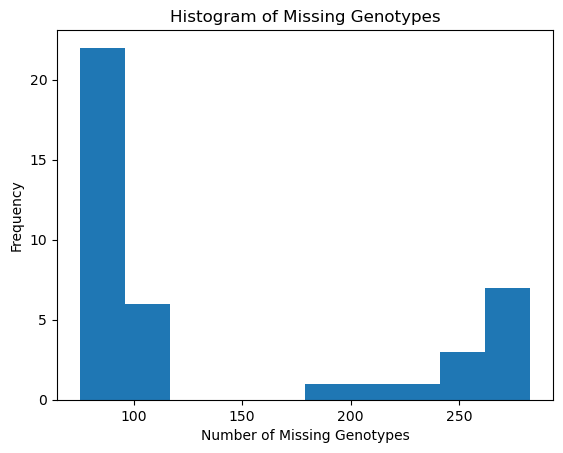

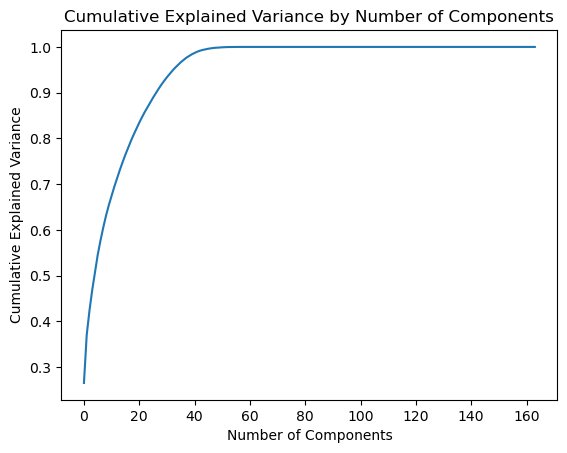

Number of components to explain 95% of variance: 34


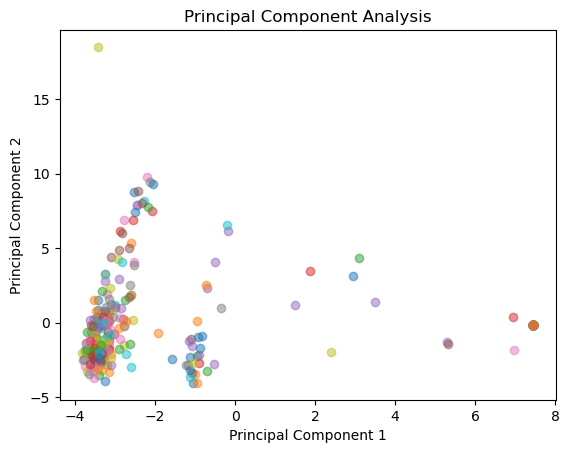

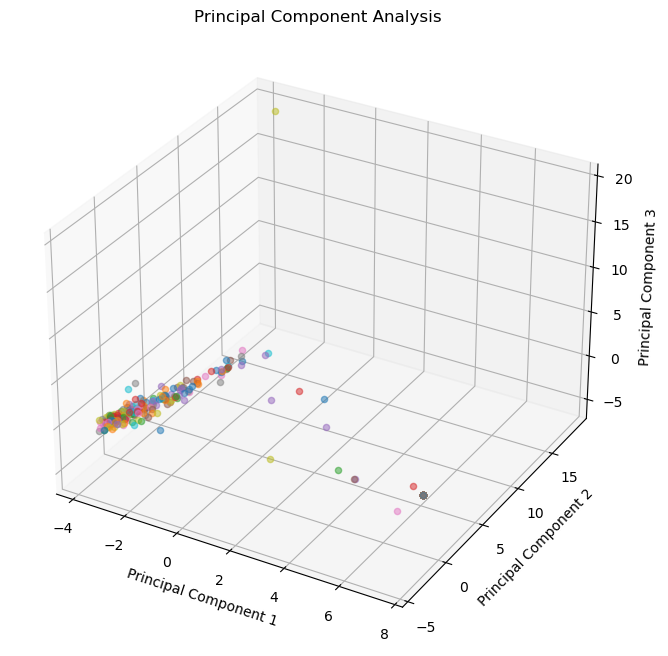

In [4]:
print("Matrix shape:", matrix.shape)

plt.hist(missing_data_counts.values(), bins=10)
plt.xlabel('Number of Missing Genotypes')
plt.ylabel('Frequency')
plt.title('Histogram of Missing Genotypes')
plt.show()

scaling = StandardScaler()
scaled_data = scaling.fit_transform(matrix)

pca = PCA(random_state=0)
principal_components = pca.fit_transform(scaled_data)

# Plot explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.show()

# Determine the number of components
explained_variance = pca.explained_variance_ratio_
total_variance = np.sum(explained_variance)
cumulative_variance = np.cumsum(explained_variance)
num_components = np.where(cumulative_variance >= 0.95 * total_variance)[0][0] + 1

print(f"Number of components to explain 95% of variance: {num_components}")

# Perform PCA with the chosen number of components
pca = PCA(n_components=num_components, random_state=0)
principal_components = pca.fit_transform(scaled_data)

for i in range(len(principal_components)):
    plt.scatter(principal_components[i, 0], principal_components[i, 1], marker='o', alpha=0.5, label=file_legend[i])

plt.title('Principal Component Analysis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Plot PCA for the first three components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(principal_components)):
    ax.scatter(
        principal_components[i, 0],
        principal_components[i, 1],
        principal_components[i, 2],
        marker='o',
        alpha=0.5,
        label=file_legend[i]
    )

ax.set_title('Principal Component Analysis')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

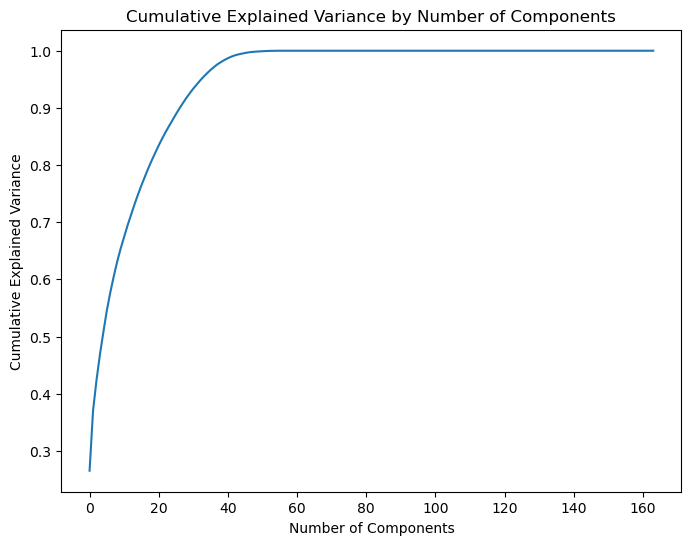

Number of components to explain 95% of variance: 34


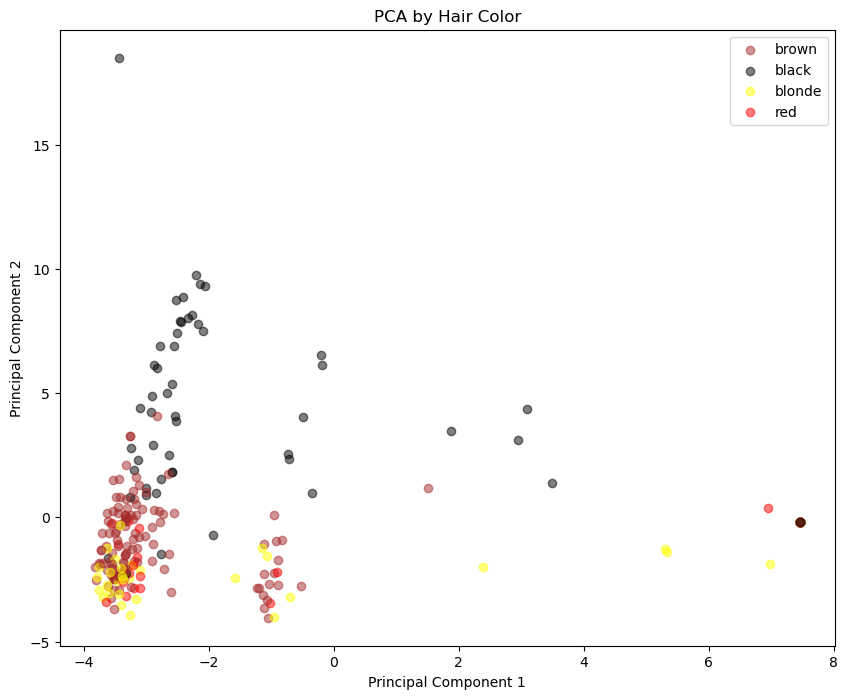

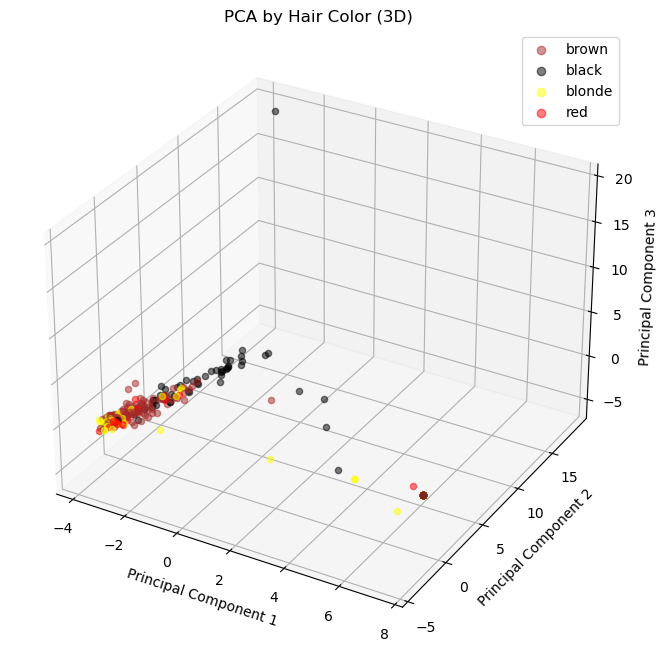

In [5]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Color mapping for different hair colors
hair_color_colors = {'black': 'black', 'blonde': 'yellow', 'red': 'red', 'brown': 'brown'}

# Standardizing the data
scaling = StandardScaler()
scaled_data = scaling.fit_transform(matrix)

# Performing PCA
pca = PCA(random_state=0)
principal_components = pca.fit_transform(scaled_data)

# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.show()

# Determine the number of components to explain at least 95% of the variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
total_variance = 0.95
num_components = np.where(cumulative_variance >= total_variance)[0][0] + 1
print(f"Number of components to explain 95% of variance: {num_components}")

# Redo PCA with the optimal number of components
pca_opt = PCA(n_components=num_components, random_state=0)
principal_components_opt = pca_opt.fit_transform(scaled_data)

# 2D Scatter plot by hair color
plt.figure(figsize=(10, 8))
for i, color in enumerate(hair_colors):
    plt.scatter(principal_components_opt[i, 0], principal_components_opt[i, 1], color=hair_color_colors[color], label=color, alpha=0.5)

# Create a legend with unique colors
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Creating unique entries for legend
plt.legend(by_label.values(), by_label.keys())

plt.title('PCA by Hair Color')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D Scatter plot by hair color
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i, color in enumerate(hair_colors):
    ax.scatter(
        principal_components_opt[i, 0],
        principal_components_opt[i, 1],
        principal_components_opt[i, 2],
        color=hair_color_colors[color],
        label=color,
        alpha=0.5
    )

ax.set_title('PCA by Hair Color (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend(by_label.values(), by_label.keys())
plt.show()


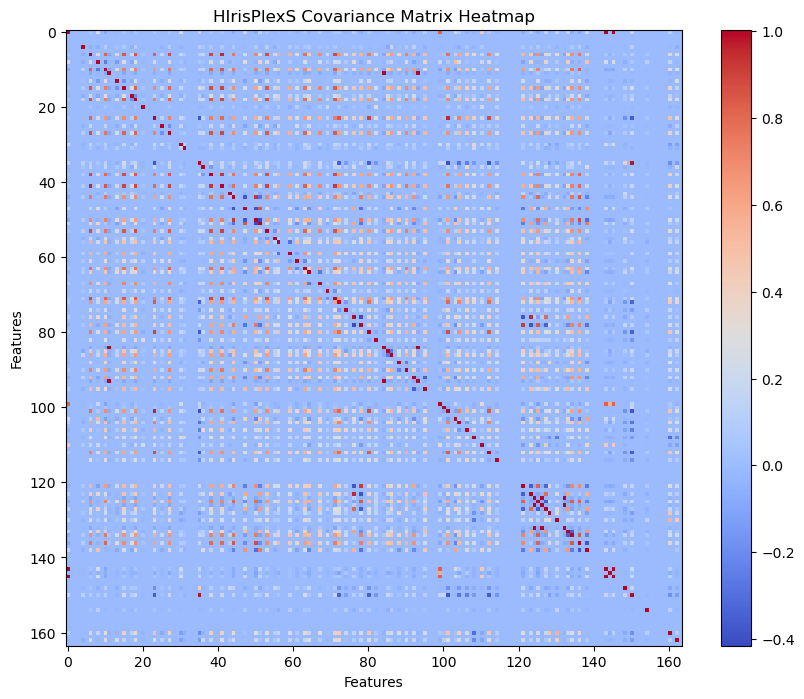

In [6]:
covariance_matrix = np.cov(scaled_data.T)

# Plot the covariance matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(covariance_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('HIrisPlexS Covariance Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [7]:
# Baseline classifier (unbalanced classes)

pca = PCA(n_components=34, random_state=0)
principal_components = pca.fit_transform(scaled_data)

overall_accuracies = []
hair_color_accuracies_list = []

# Perform 100 trials
for _ in range(100):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(principal_components, hair_colors, test_size=0.1)

    # Predictions based on uniform distribution over all classes
    classes = np.unique(y_train)
    probs = [1 / len(classes) for _ in classes]
    y_pred_baseline = np.random.choice(classes, size=len(X_test), p=probs)

    # Calculate confusion matrix
    conf_matrix_baseline = confusion_matrix(y_test, y_pred_baseline, labels=list(set(hair_colors)))

    # Calculate accuracy for each hair color
    hair_color_accuracies_baseline = {}
    for i, color in enumerate(set(hair_colors)):
        # True Positives are on the diagonal
        true_positives = conf_matrix_baseline[i, i]
        total_color = sum(conf_matrix_baseline[i, :])  # Total instances of this hair color
        if total_color > 0:
            color_accuracy = true_positives / total_color
            hair_color_accuracies_baseline[color] = color_accuracy

    # Append overall accuracy and hair color accuracies to lists
    overall_accuracies.append(np.mean(list(hair_color_accuracies_baseline.values())))
    hair_color_accuracies_list.append(hair_color_accuracies_baseline)

# Calculate average overall accuracy
average_overall_accuracy = np.mean(overall_accuracies)
print("Average Overall Accuracy:", average_overall_accuracy)

# Calculate and print the average accuracy for each hair color
average_hair_color_accuracies = {}
for color in set(hair_colors):
    color_accuracies = [trial[color] for trial in hair_color_accuracies_list if color in trial]
    if color_accuracies:
        average_accuracy = np.mean(color_accuracies)
        average_hair_color_accuracies[color] = average_accuracy
        print(f"Average Accuracy for {color}: {average_accuracy:.2f}")

Average Overall Accuracy: 0.25456773980448516
Average Accuracy for black: 0.27
Average Accuracy for red: 0.26
Average Accuracy for brown: 0.25
Average Accuracy for blonde: 0.23


In [8]:
# Baseline classifier

overall_accuracies = []
hair_color_accuracies_list = []

# Perform 100 trials
for _ in range(100):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(principal_components, hair_colors, test_size=0.1, stratify=hair_colors)

    # Calculate class frequencies from the training set
    class_freq = {}
    total_samples = len(y_train)
    for class_ in set(y_train):
        class_count = np.sum(y_train == class_)
        class_freq[class_] = class_count / total_samples

    # Predictions based on background class frequencies
    classes = list(class_freq.keys())
    probs = [class_freq[class_] for class_ in classes]
    probs_sum = sum(probs)
    if probs_sum > 0:  # Ensure that probabilities are not all zero
        probs = [prob / probs_sum for prob in probs]  # Normalize probabilities
    else:
        probs = [1 / len(classes) for _ in classes]  # Uniform distribution if all probabilities are zero
    y_pred_baseline = np.random.choice(classes, size=len(X_test), p=probs)

    # Calculate confusion matrix
    conf_matrix_baseline = confusion_matrix(y_test, y_pred_baseline, labels=list(set(hair_colors)))

    # Calculate accuracy for each hair color
    hair_color_accuracies_baseline = {}
    for i, color in enumerate(set(hair_colors)):
        # True Positives are on the diagonal
        true_positives = conf_matrix_baseline[i, i]
        total_color = sum(conf_matrix_baseline[i, :])  # Total instances of this hair color
        if total_color > 0:
            color_accuracy = true_positives / total_color
            hair_color_accuracies_baseline[color] = color_accuracy

    # Append overall accuracy and hair color accuracies to lists
    overall_accuracies.append(np.mean(list(hair_color_accuracies_baseline.values())))
    hair_color_accuracies_list.append(hair_color_accuracies_baseline)

# Calculate average overall accuracy
average_overall_accuracy = np.mean(overall_accuracies)
print("Average Overall Accuracy:", average_overall_accuracy)

# Calculate and print the average accuracy for each hair color
average_hair_color_accuracies = {}
for color in set(hair_colors):
    color_accuracies = [trial[color] for trial in hair_color_accuracies_list if color in trial]
    if color_accuracies:
        average_accuracy = np.mean(color_accuracies)
        average_hair_color_accuracies[color] = average_accuracy
        print(f"Average Accuracy for {color}: {average_accuracy:.2f}")

Average Overall Accuracy: 0.2545416666666666
Average Accuracy for black: 0.24
Average Accuracy for red: 0.24
Average Accuracy for brown: 0.26
Average Accuracy for blonde: 0.28


283


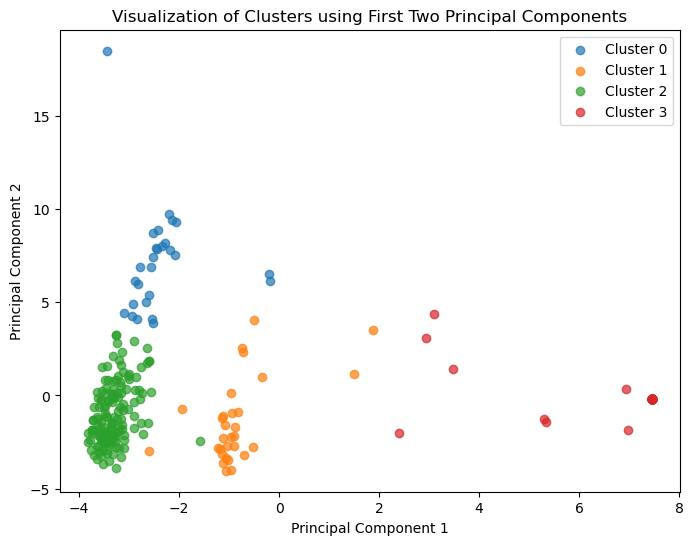

Cluster 3:
  Hair Color: brown, Count: 40, Percentage: 50.00%
  Hair Color: blonde, Count: 19, Percentage: 23.75%
  Hair Color: red, Count: 4, Percentage: 5.00%
  Hair Color: black, Count: 17, Percentage: 21.25%

Cluster 2:
  Hair Color: brown, Count: 94, Percentage: 64.38%
  Hair Color: black, Count: 16, Percentage: 10.96%
  Hair Color: blonde, Count: 23, Percentage: 15.75%
  Hair Color: red, Count: 13, Percentage: 8.90%

Cluster 1:
  Hair Color: red, Count: 2, Percentage: 6.67%
  Hair Color: brown, Count: 18, Percentage: 60.00%
  Hair Color: black, Count: 6, Percentage: 20.00%
  Hair Color: blonde, Count: 4, Percentage: 13.33%

Cluster 0:
  Hair Color: black, Count: 26, Percentage: 96.30%
  Hair Color: brown, Count: 1, Percentage: 3.70%



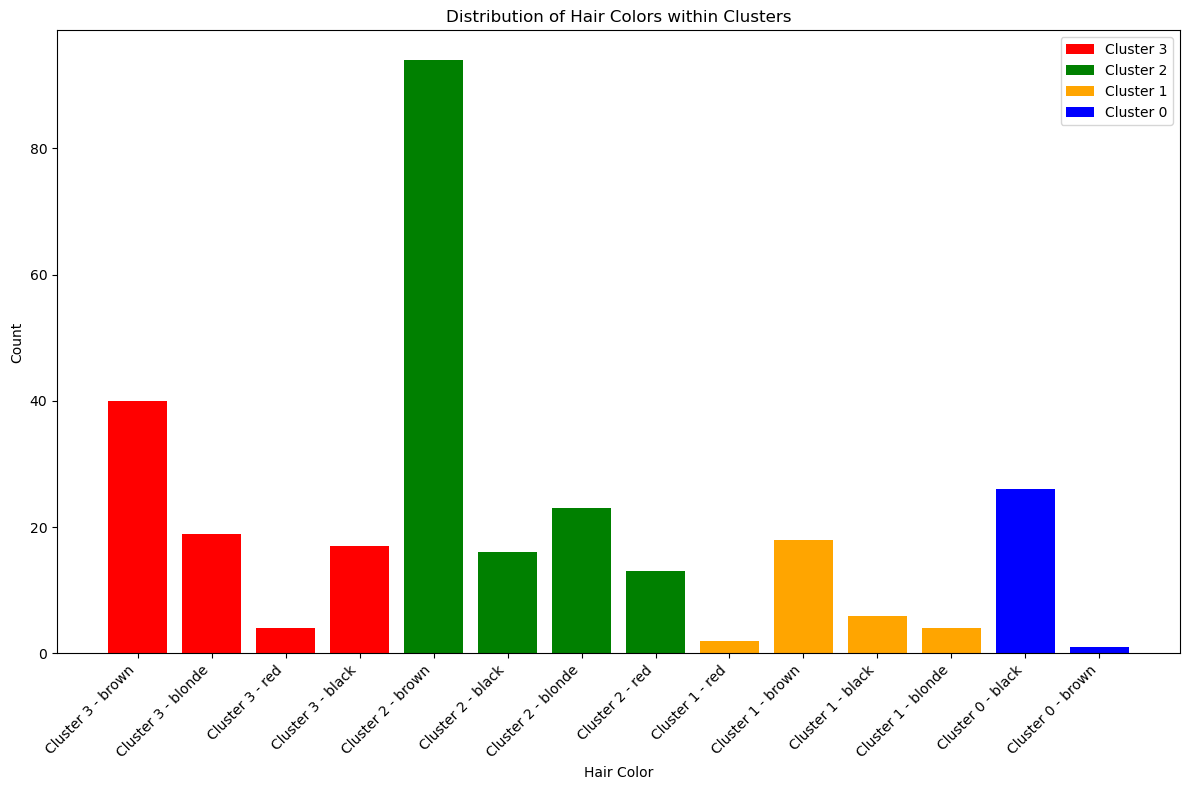

In [9]:
from sklearn.cluster import KMeans

# Create a copy of hair_colors before applying K-means
original_hair_colors = hair_colors[:]

# Perform PCA and K-means clustering
pca = PCA(n_components=34, random_state=0)
principal_components = pca.fit_transform(scaled_data)
kmeans = KMeans(n_clusters=4, random_state=0)
cluster_labels = kmeans.fit_predict(principal_components)

# Now use original_hair_colors for analysis
print(len(original_hair_colors))  # This should still print 283

# Plot the first two principal components
plt.figure(figsize=(8, 6))
for label in set(cluster_labels):
    plt.scatter(principal_components[cluster_labels == label, 0], 
                principal_components[cluster_labels == label, 1], 
                label=f'Cluster {label}', alpha=0.7)
plt.title('Visualization of Clusters using First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

from collections import defaultdict

# Initialize a dictionary to store the count of each hair color in each cluster
hair_color_counts_per_cluster = defaultdict(lambda: defaultdict(int))

# Count the occurrences of each hair color in each cluster
for cluster, hair_color in zip(cluster_labels, hair_colors):
    hair_color_counts_per_cluster[cluster][hair_color] += 1

# Print the distribution of hair colors in each cluster
for cluster, hair_color_counts in hair_color_counts_per_cluster.items():
    total_samples = sum(hair_color_counts.values())
    print(f"Cluster {cluster}:")
    for hair_color, count in hair_color_counts.items():
        percentage = (count / total_samples) * 100
        print(f"  Hair Color: {hair_color}, Count: {count}, Percentage: {percentage:.2f}%")
    print()


# Define colors for each hair color
colors = ['blue', 'orange', 'green', 'red', 'purple']  # You can adjust/add colors as needed

# Plot the distribution of hair colors within each cluster
plt.figure(figsize=(12, 8))
for cluster, hair_color_counts in hair_color_counts_per_cluster.items():
    hair_colors = list(hair_color_counts.keys())
    counts = list(hair_color_counts.values())
    plt.bar([f'Cluster {cluster} - {color}' for color in hair_colors], 
            counts, 
            color=colors[cluster % len(colors)], 
            label=f'Cluster {cluster}')

plt.title('Distribution of Hair Colors within Clusters')
plt.xlabel('Hair Color')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show() 


In [10]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, v_measure_score

adjusted_rand = adjusted_rand_score(original_hair_colors, cluster_labels)
normalized_mutual_info = normalized_mutual_info_score(original_hair_colors, cluster_labels)
v_measure = v_measure_score(original_hair_colors, cluster_labels)

print(f"Adjusted Rand Index: {adjusted_rand}")
print(f"Normalized Mutual Information: {normalized_mutual_info}")
print(f"V-measure: {v_measure}")

Adjusted Rand Index: 0.1058980817801176
Normalized Mutual Information: 0.13454967424234812
V-measure: 0.13454967424234815


In [11]:
hair_colors = original_hair_colors[:]

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=34, random_state=0)
principal_components = pca.fit_transform(scaled_data)

# Initialize variables to store accuracy scores
overall_accuracies = []
hair_color_accuracies_list = []

# Perform 100 trials
for _ in range(100):
    # Split the data with stratification and 90% training size
    X_train, X_test, y_train, y_test = train_test_split(principal_components, hair_colors, test_size=0.1, stratify=hair_colors)

    # Define the parameter grid for grid search
    param_grid = {
        'n_estimators': [100],  # Number of trees in the forest
        'max_depth': [None, 10, 20, 30],   # Maximum depth of the trees
        'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
    }

    # Initialize the Random Forest classifier
    rf = RandomForestClassifier()

    # Perform grid search
    grid_search = GridSearchCV(rf, param_grid, cv=5)  # 5-fold cross-validation
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_

    # Initialize the Random Forest classifier with the best parameters
    clf = RandomForestClassifier(**best_params)

    # Train the Random Forest classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model and append the overall accuracy score to the list
    overall_accuracy = accuracy_score(y_test, y_pred)
    overall_accuracies.append(overall_accuracy)

    # Calculate accuracy for each hair color
    conf_matrix = confusion_matrix(y_test, y_pred, labels=list(set(hair_colors)))
    hair_color_accuracies = {}
    for i, color in enumerate(set(hair_colors)):
        # True Positives are on the diagonal
        true_positives = conf_matrix[i, i]
        total_color = sum(conf_matrix[i, :])  # Total instances of this hair color
        if total_color > 0:
            color_accuracy = true_positives / total_color
            hair_color_accuracies[color] = color_accuracy
    hair_color_accuracies_list.append(hair_color_accuracies)

    # Print the best parameters for this iteration
    print("Best parameters for this iteration:", best_params)

# Calculate the average overall accuracy
average_overall_accuracy = np.mean(overall_accuracies)
print("Average Overall Accuracy:", average_overall_accuracy)

# Calculate and print the average accuracy for each hair color
average_hair_color_accuracies = {}
for color in set(hair_colors):
    color_accuracies = [trial[color] for trial in hair_color_accuracies_list if color in trial]
    if color_accuracies:
        average_accuracy = np.mean(color_accuracies)
        average_hair_color_accuracies[color] = average_accuracy
        print(f"Average Accuracy for {color}: {average_accuracy:.2f}")

Best parameters for this iteration: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters

In [13]:
# Random Forest (class balance)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=34, random_state=0)
principal_components = pca.fit_transform(scaled_data)

# Initialize variables to store accuracy scores
overall_accuracies = []
hair_color_accuracies_list = []

# Perform 100 trials
for _ in range(100):
    # Split the data with stratification and 90% training size
    X_train, X_test, y_train, y_test = train_test_split(principal_components, hair_colors, test_size=0.1, stratify=hair_colors)

    # Define the parameter grid for grid search
    param_grid = {
        'n_estimators': [100],  # Number of trees in the forest
        'max_depth': [None, 10, 20, 30],   # Maximum depth of the trees
        'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
    }

    # Initialize the Random Forest classifier
    rf = RandomForestClassifier(class_weight='balanced')

    # Perform grid search
    grid_search = GridSearchCV(rf, param_grid, cv=5)  # 5-fold cross-validation
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_

    # Initialize the Random Forest classifier with the best parameters
    clf = RandomForestClassifier(class_weight='balanced', **best_params)

    # Train the Random Forest classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model and append the overall accuracy score to the list
    overall_accuracy = accuracy_score(y_test, y_pred)
    overall_accuracies.append(overall_accuracy)

    # Calculate accuracy for each hair color
    conf_matrix = confusion_matrix(y_test, y_pred, labels=list(set(hair_colors)))
    hair_color_accuracies = {}
    for i, color in enumerate(set(hair_colors)):
        # True Positives are on the diagonal
        true_positives = conf_matrix[i, i]
        total_color = sum(conf_matrix[i, :])  # Total instances of this hair color
        if total_color > 0:
            color_accuracy = true_positives / total_color
            hair_color_accuracies[color] = color_accuracy
    hair_color_accuracies_list.append(hair_color_accuracies)

    # Print the best parameters for this iteration
    print("Best parameters for this iteration:", best_params)

# Calculate the average overall accuracy
average_overall_accuracy = np.mean(overall_accuracies)
print("Average Overall Accuracy:", average_overall_accuracy)

# Calculate and print the average accuracy for each hair color
average_hair_color_accuracies = {}
for color in set(hair_colors):
    color_accuracies = [trial[color] for trial in hair_color_accuracies_list if color in trial]
    if color_accuracies:
        average_accuracy = np.mean(color_accuracies)
        average_hair_color_accuracies[color] = average_accuracy
        print(f"Average Accuracy for {color}: {average_accuracy:.2f}")

Best parameters for this iteration: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for this iteration: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best parameters for

Overall Accuracy: 0.5862068965517241
Accuracy for black: 0.33
Accuracy for red: 0.00
Accuracy for brown: 0.94
Accuracy for blonde: 0.00


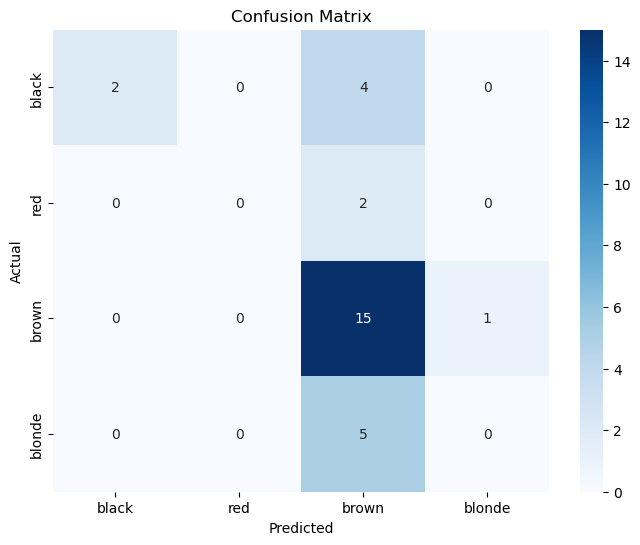

In [14]:
from sklearn.svm import SVC
import seaborn as sns

pca_opt = PCA(n_components=34, random_state=0)
principal_components_opt = pca_opt.fit_transform(scaled_data)

X_train, X_test, y_train, y_test = train_test_split(principal_components, hair_colors, test_size=0.1, stratify=hair_colors)

# Define the parameter grid for grid search
param_grid = {'C': [0.1, 1, 10, 100]}  # Specify the range of C values to search over

# Initialize the SVM classifier
clf = SVC(kernel='linear', random_state=0)

# Perform grid search
grid_search = GridSearchCV(clf, param_grid, cv=5)  # 5-fold cross-validation
grid_search.fit(X_train, y_train)

# Get the best value of C (regularization parameter)
best_C = grid_search.best_params_['C']

# Initialize and train the SVM classifier with the best C value
clf = SVC(kernel='linear', C=best_C, random_state=0)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model and append the overall accuracy score to the list
overall_accuracy = accuracy_score(y_test, y_pred)

# Calculate accuracy for each hair color
conf_matrix = confusion_matrix(y_test, y_pred, labels=list(set(hair_colors)))
hair_color_accuracies = {}
for i, color in enumerate(set(hair_colors)):
    # True Positives are on the diagonal
    true_positives = conf_matrix[i, i]
    total_color = sum(conf_matrix[i, :])  # Total instances of this hair color
    if total_color > 0:
        color_accuracy = true_positives / total_color
        hair_color_accuracies[color] = color_accuracy

# Calculate the average overall accuracy
average_overall_accuracy = overall_accuracy
print("Overall Accuracy:", average_overall_accuracy)

# Calculate and print the average accuracy for each hair color
for color, accuracy in hair_color_accuracies.items():
    print(f"Accuracy for {color}: {accuracy:.2f}")
    
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(hair_colors), yticklabels=set(hair_colors))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
overall_accuracies = []
hair_color_accuracies_list = []

# Perform 100 trials
for _ in range(100):
    # Split the data with stratification and 90% training size
    X_train, X_test, y_train, y_test = train_test_split(principal_components, hair_colors, test_size=0.1, stratify=hair_colors)

    # Define the parameter grid for grid search
    param_grid = {'C': [0.1, 1, 10, 100]}  # Specify the range of C values to search over

    # Initialize the SVM classifier
    clf = SVC(kernel='linear', random_state=0)

    # Perform grid search
    grid_search = GridSearchCV(clf, param_grid, cv=5)  # 5-fold cross-validation
    grid_search.fit(X_train, y_train)

    # Get the best value of C (regularization parameter)
    best_C = grid_search.best_params_['C']

    # Initialize and train the SVM classifier with the best C value
    clf = SVC(kernel='linear', C=best_C, random_state=0)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model and append the overall accuracy score to the list
    overall_accuracy = accuracy_score(y_test, y_pred)
    overall_accuracies.append(overall_accuracy)

    # Calculate accuracy for each hair color
    conf_matrix = confusion_matrix(y_test, y_pred, labels=list(set(hair_colors)))
    hair_color_accuracies = {}
    for i, color in enumerate(set(hair_colors)):
        # True Positives are on the diagonal
        true_positives = conf_matrix[i, i]
        total_color = sum(conf_matrix[i, :])  # Total instances of this hair color
        if total_color > 0:
            color_accuracy = true_positives / total_color
            hair_color_accuracies[color] = color_accuracy
    hair_color_accuracies_list.append(hair_color_accuracies)

# Calculate the average overall accuracy
average_overall_accuracy = np.mean(overall_accuracies)
print("Average Overall Accuracy:", average_overall_accuracy)

# Calculate and print the average accuracy for each hair color
average_hair_color_accuracies = {}
for color in set(hair_colors):
    color_accuracies = [trial[color] for trial in hair_color_accuracies_list if color in trial]
    if color_accuracies:
        average_accuracy = np.mean(color_accuracies)
        average_hair_color_accuracies[color] = average_accuracy
        print(f"Average Accuracy for {color}: {average_accuracy:.2f}")

Average Overall Accuracy: 0.689655172413793
Average Accuracy for black: 0.67
Average Accuracy for red: 0.16
Average Accuracy for brown: 0.88
Average Accuracy for blonde: 0.31


In [16]:
#SVM Model (class balance)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import numpy as np

hair_colors = original_hair_colors[:]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(principal_components, hair_colors, test_size=0.1, stratify=hair_colors)

overall_accuracies = []
hair_color_accuracies_list = []

# Perform 100 trials
for _ in range(100):
    # Define the parameter grid for grid search
    param_grid = {'C': [0.1, 1, 10, 100]}  # Specify the range of C values to search over

    # Initialize the SVM classifier
    clf = SVC(kernel='linear', class_weight='balanced', random_state=0)

    # Perform grid search
    grid_search = GridSearchCV(clf, param_grid, cv=5)  # 5-fold cross-validation
    grid_search.fit(X_train, y_train)

    # Get the best value of C (regularization parameter)
    best_C = grid_search.best_params_['C']

    # Initialize and train the SVM classifier with the best C value
    clf = SVC(kernel='linear', C=best_C, class_weight='balanced', random_state=0)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model and append the overall accuracy score to the list
    overall_accuracy = accuracy_score(y_test, y_pred)
    overall_accuracies.append(overall_accuracy)

    # Calculate accuracy for each hair color
    conf_matrix = confusion_matrix(y_test, y_pred, labels=list(set(hair_colors)))
    hair_color_accuracies = {}
    for i, color in enumerate(set(hair_colors)):
        # True Positives are on the diagonal
        true_positives = conf_matrix[i, i]
        total_color = sum(conf_matrix[i, :])  # Total instances of this hair color
        if total_color > 0:
            color_accuracy = true_positives / total_color
            hair_color_accuracies[color] = color_accuracy
    hair_color_accuracies_list.append(hair_color_accuracies)

# Calculate the average overall accuracy
average_overall_accuracy = np.mean(overall_accuracies)
print("Average Overall Accuracy:", average_overall_accuracy)

# Calculate and print the average accuracy for each hair color
average_hair_color_accuracies = {}
for color in set(hair_colors):
    color_accuracies = [trial[color] for trial in hair_color_accuracies_list if color in trial]
    if color_accuracies:
        average_accuracy = np.mean(color_accuracies)
        average_hair_color_accuracies[color] = average_accuracy
        print(f"Average Accuracy for {color}: {average_accuracy:.2f}")

Average Overall Accuracy: 0.5172413793103449
Average Accuracy for black: 0.50
Average Accuracy for red: 0.00
Average Accuracy for brown: 0.50
Average Accuracy for blonde: 0.80


In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

pca = PCA(n_components=34, random_state=0)
principal_components = pca.fit_transform(scaled_data)

# Initialize variables to store accuracy scores
overall_accuracies = []
hair_color_accuracies_list = []

# Perform 100 trials
for _ in range(100):
    # Split the data with stratification and 90% training size
    X_train, X_test, y_train, y_test = train_test_split(principal_components, hair_colors, test_size=0.1, stratify=hair_colors)

    # Define the parameter grid for grid search
    param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,21,22,23,24,25,26,27,28,29,30]}  # Specify the range of k values to search over

    # Initialize the KNN classifier
    knn = KNeighborsClassifier()

    # Perform grid search
    grid_search = GridSearchCV(knn, param_grid, cv=5)  # 5-fold cross-validation
    grid_search.fit(X_train, y_train)

    # Get the best value of k (number of neighbors)
    best_k = grid_search.best_params_['n_neighbors']

    # Initialize the KNN classifier with the best k value
    clf = KNeighborsClassifier(n_neighbors=best_k)

    # Train the KNN classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model and append the overall accuracy score to the list
    overall_accuracy = accuracy_score(y_test, y_pred)
    overall_accuracies.append(overall_accuracy)

    # Calculate accuracy for each hair color
    conf_matrix = confusion_matrix(y_test, y_pred, labels=list(set(hair_colors)))
    hair_color_accuracies = {}
    for i, color in enumerate(set(hair_colors)):
        # True Positives are on the diagonal
        true_positives = conf_matrix[i, i]
        total_color = sum(conf_matrix[i, :])  # Total instances of this hair color
        if total_color > 0:
            color_accuracy = true_positives / total_color
            hair_color_accuracies[color] = color_accuracy
    hair_color_accuracies_list.append(hair_color_accuracies)

    # Print the best k for this iteration
    print("Best k for this iteration:", best_k)

# Calculate the average overall accuracy
average_overall_accuracy = np.mean(overall_accuracies)
print("Average Overall Accuracy:", average_overall_accuracy)

# Calculate and print the average accuracy for each hair color
average_hair_color_accuracies = {}
for color in set(hair_colors):
    color_accuracies = [trial[color] for trial in hair_color_accuracies_list if color in trial]
    if color_accuracies:
        average_accuracy = np.mean(color_accuracies)
        average_hair_color_accuracies[color] = average_accuracy
        print(f"Average Accuracy for {color}: {average_accuracy:.2f}")

Best k for this iteration: 19
Best k for this iteration: 11
Best k for this iteration: 9
Best k for this iteration: 12
Best k for this iteration: 6
Best k for this iteration: 20
Best k for this iteration: 13
Best k for this iteration: 14
Best k for this iteration: 20
Best k for this iteration: 10
Best k for this iteration: 26
Best k for this iteration: 11
Best k for this iteration: 6
Best k for this iteration: 17
Best k for this iteration: 15
Best k for this iteration: 17
Best k for this iteration: 10
Best k for this iteration: 10
Best k for this iteration: 17
Best k for this iteration: 13
Best k for this iteration: 9
Best k for this iteration: 17
Best k for this iteration: 12
Best k for this iteration: 4
Best k for this iteration: 5
Best k for this iteration: 15
Best k for this iteration: 12
Best k for this iteration: 6
Best k for this iteration: 8
Best k for this iteration: 6
Best k for this iteration: 14
Best k for this iteration: 11
Best k for this iteration: 13
Best k for this ite

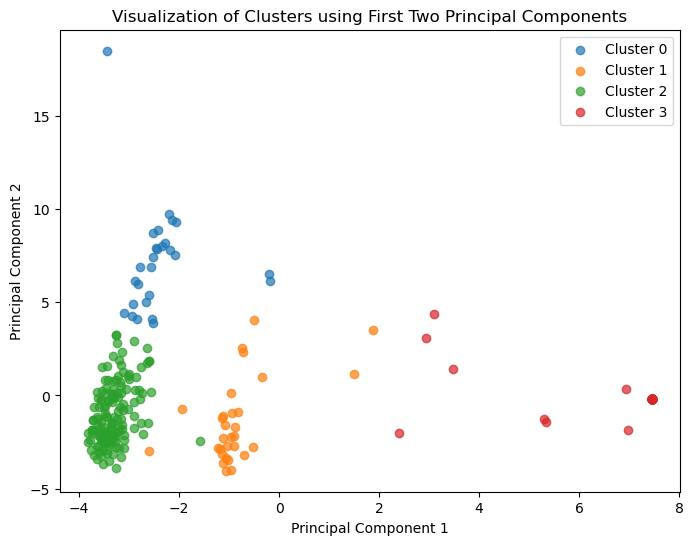

Cluster 3:
  Hair Color: brown, Count: 40, Percentage: 50.00%
  Hair Color: blonde, Count: 19, Percentage: 23.75%
  Hair Color: red, Count: 4, Percentage: 5.00%
  Hair Color: black, Count: 17, Percentage: 21.25%

Cluster 2:
  Hair Color: brown, Count: 94, Percentage: 64.38%
  Hair Color: black, Count: 16, Percentage: 10.96%
  Hair Color: blonde, Count: 23, Percentage: 15.75%
  Hair Color: red, Count: 13, Percentage: 8.90%

Cluster 1:
  Hair Color: red, Count: 2, Percentage: 6.67%
  Hair Color: brown, Count: 18, Percentage: 60.00%
  Hair Color: black, Count: 6, Percentage: 20.00%
  Hair Color: blonde, Count: 4, Percentage: 13.33%

Cluster 0:
  Hair Color: black, Count: 26, Percentage: 96.30%
  Hair Color: brown, Count: 1, Percentage: 3.70%



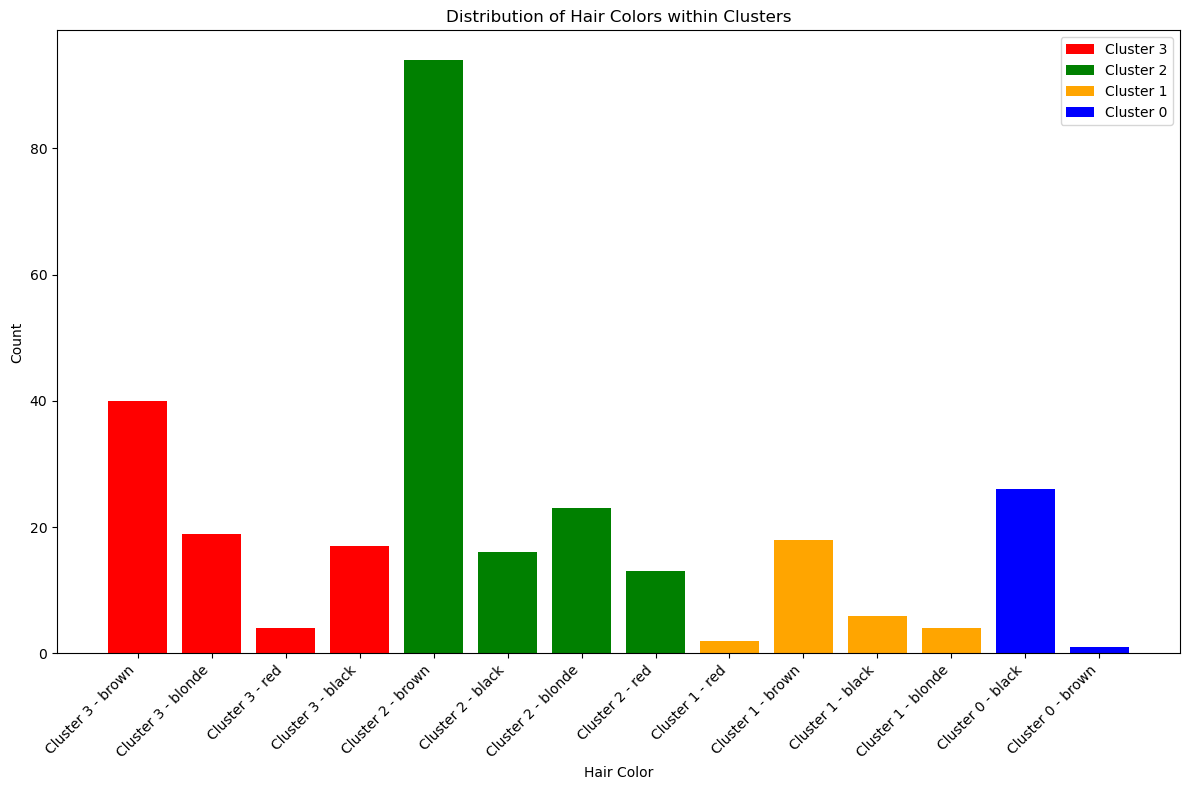

In [18]:
from sklearn.cluster import KMeans

pca = PCA(n_components=34, random_state=0)
principal_components = pca.fit_transform(scaled_data)

# Perform k-means clustering
kmeans = KMeans(n_clusters=4, random_state=0)  # Adjust the number of clusters as needed
cluster_labels = kmeans.fit_predict(principal_components)


# Plot the first two principal components
plt.figure(figsize=(8, 6))
for label in set(cluster_labels):
    plt.scatter(principal_components[cluster_labels == label, 0], 
                principal_components[cluster_labels == label, 1], 
                label=f'Cluster {label}', alpha=0.7)
plt.title('Visualization of Clusters using First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

from collections import defaultdict

# Initialize a dictionary to store the count of each hair color in each cluster
hair_color_counts_per_cluster = defaultdict(lambda: defaultdict(int))

# Count the occurrences of each hair color in each cluster
for cluster, hair_color in zip(cluster_labels, hair_colors):
    hair_color_counts_per_cluster[cluster][hair_color] += 1

# Print the distribution of hair colors in each cluster
for cluster, hair_color_counts in hair_color_counts_per_cluster.items():
    total_samples = sum(hair_color_counts.values())
    print(f"Cluster {cluster}:")
    for hair_color, count in hair_color_counts.items():
        percentage = (count / total_samples) * 100
        print(f"  Hair Color: {hair_color}, Count: {count}, Percentage: {percentage:.2f}%")
    print()


# Define colors for each hair color
colors = ['blue', 'orange', 'green', 'red', 'purple']  # You can adjust/add colors as needed

# Plot the distribution of hair colors within each cluster
plt.figure(figsize=(12, 8))
for cluster, hair_color_counts in hair_color_counts_per_cluster.items():
    hair_colors = list(hair_color_counts.keys())
    counts = list(hair_color_counts.values())
    plt.bar([f'Cluster {cluster} - {color}' for color in hair_colors], 
            counts, 
            color=colors[cluster % len(colors)], 
            label=f'Cluster {cluster}')

plt.title('Distribution of Hair Colors within Clusters')
plt.xlabel('Hair Color')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
#KNN (class balance)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

pca = PCA(n_components=34, random_state=0)
principal_components = pca.fit_transform(scaled_data)

# Initialize variables to store accuracy scores
overall_accuracies = []
hair_color_accuracies_list = []


hair_colors = original_hair_colors[:]

# Perform 100 trials
for _ in range(100):
    # Split the data with stratification and 90% training size
    X_train, X_test, y_train, y_test = train_test_split(principal_components, hair_colors, test_size=0.1, stratify=hair_colors)

    # Define the parameter grid for grid search
    param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,21,22,23,24,25,26,27,28,29,30]}  # Specify the range of k values to search over

    # Initialize the KNN classifier
    knn = KNeighborsClassifier(weights='distance')

    # Perform grid search
    grid_search = GridSearchCV(knn, param_grid, cv=5)  # 5-fold cross-validation
    grid_search.fit(X_train, y_train)

    # Get the best value of k (number of neighbors)
    best_k = grid_search.best_params_['n_neighbors']

    # Initialize the KNN classifier with the best k value
    clf = KNeighborsClassifier(n_neighbors=best_k, weights='distance')

    # Train the KNN classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model and append the overall accuracy score to the list
    overall_accuracy = accuracy_score(y_test, y_pred)
    overall_accuracies.append(overall_accuracy)

    # Calculate accuracy for each hair color
    conf_matrix = confusion_matrix(y_test, y_pred, labels=list(set(hair_colors)))
    hair_color_accuracies = {}
    for i, color in enumerate(set(hair_colors)):
        # True Positives are on the diagonal
        true_positives = conf_matrix[i, i]
        total_color = sum(conf_matrix[i, :])  # Total instances of this hair color
        if total_color > 0:
            color_accuracy = true_positives / total_color
            hair_color_accuracies[color] = color_accuracy
    hair_color_accuracies_list.append(hair_color_accuracies)

    # Print the best k for this iteration
    print("Best k for this iteration:", best_k)

# Calculate the average overall accuracy
average_overall_accuracy = np.mean(overall_accuracies)
print("Average Overall Accuracy:", average_overall_accuracy)

# Calculate and print the average accuracy for each hair color
average_hair_color_accuracies = {}
for color in set(hair_colors):
    color_accuracies = [trial[color] for trial in hair_color_accuracies_list if color in trial]
    if color_accuracies:
        average_accuracy = np.mean(color_accuracies)
        average_hair_color_accuracies[color] = average_accuracy
        print(f"Average Accuracy for {color}: {average_accuracy:.2f}")

Best k for this iteration: 11
Best k for this iteration: 20
Best k for this iteration: 19
Best k for this iteration: 8
Best k for this iteration: 10
Best k for this iteration: 10
Best k for this iteration: 30
Best k for this iteration: 12
Best k for this iteration: 17
Best k for this iteration: 10
Best k for this iteration: 7
Best k for this iteration: 13
Best k for this iteration: 14
Best k for this iteration: 24
Best k for this iteration: 10
Best k for this iteration: 16
Best k for this iteration: 4
Best k for this iteration: 13
Best k for this iteration: 16
Best k for this iteration: 14
Best k for this iteration: 7
Best k for this iteration: 14
Best k for this iteration: 21
Best k for this iteration: 23
Best k for this iteration: 16
Best k for this iteration: 3
Best k for this iteration: 3
Best k for this iteration: 7
Best k for this iteration: 3
Best k for this iteration: 16
Best k for this iteration: 4
Best k for this iteration: 9
Best k for this iteration: 13
Best k for this iter

In [20]:
from sklearn.decomposition import PCA
import pandas as pd

# Assuming 'scaled_data' is your standardized SNP data matrix
pca = PCA(random_state=0)  # 'mle' can be replaced with the number of components you want
principal_components = pca.fit_transform(scaled_data)

# PCA loadings are the components_ attribute of the PCA object
loadings = pca.components_.T  # Transpose so that rows correspond to features

# Create a DataFrame for easier manipulation
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=matrix.columns)

# For each principal component, find the SNP with the highest loading (absolute value)
most_contributing_snps = {}
for column in loadings_df.columns:
    most_contributing_snps[column] = loadings_df[column].abs().idxmax()

print("Most contributing SNPs for each PC:", most_contributing_snps)


Most contributing SNPs for each PC: {'PC1': 'rs1110400T', 'PC2': 'rs1426654G', 'PC3': 'rs201326893C', 'PC4': 'rs312262906A', 'PC5': 'rs1667394A', 'PC6': 'rs12896399A', 'PC7': 'rs2238289A', 'PC8': 'rs2402130G', 'PC9': 'rs1393350A', 'PC10': 'rs1800407T', 'PC11': 'rs12896399T', 'PC12': 'rs1805005T', 'PC13': 'rs1805008T', 'PC14': 'rs1805007T', 'PC15': 'rs17128291G', 'PC16': 'rs2228479A', 'PC17': 'rs1545397A', 'PC18': 'rs1800407T', 'PC19': 'rs1800414A', 'PC20': 'rs12441727G', 'PC21': 'rs1110400C', 'PC22': 'rs11547464A', 'PC23': 'rs1805009C', 'PC24': 'rs1805009C', 'PC25': 'rs1805005T', 'PC26': 'rs2402130G', 'PC27': 'rs12441727G', 'PC28': 'rs1805006A', 'PC29': 'rs17128291G', 'PC30': 'rs1126809A', 'PC31': 'rs1126809A', 'PC32': 'rs8051733G', 'PC33': 'rs1805006A', 'PC34': 'rs1800414C', 'PC35': 'rs8051733G', 'PC36': 'rs2238289A', 'PC37': 'rs1805009G', 'PC38': 'rs12203592T', 'PC39': 'rs2238289G', 'PC40': 'rs885479A', 'PC41': 'rs1667394C', 'PC42': 'rs1426654G', 'PC43': 'rs1129038T', 'PC44': 'rs1689

In [21]:
import pandas as pd

# Load SNP data from each file
file_1 = '/Users/shatakshishewale/Desktop/JHU/Spring 24/Annotate a Genome/Exercises/Final Project/HIrisPlex.txt'
file_2 = '/Users/shatakshishewale/Desktop/JHU/Spring 24/Annotate a Genome/Exercises/Final Project/HIrisPlexS.txt'
file_3 = '/Users/shatakshishewale/Desktop/JHU/Spring 24/Annotate a Genome/Exercises/Final Project/snipper.txt'

# Read SNPs from each file
snps_1 = pd.read_csv(file_1, names=['SNP'], skiprows=1).SNP.tolist()
snps_2 = pd.read_csv(file_2, names=['SNP'], skiprows=1).SNP.tolist()
snps_3 = pd.read_csv(file_3, names=['SNP'], skiprows=1).SNP.tolist()

# Compute the common SNPs
common_snps = set(snps_1) & set(snps_2) & set(snps_3)

# Output the common SNPs
print("Common SNPs across all three files:", common_snps)


Common SNPs across all three files: {'rs1805008', 'rs12913832', 'rs1805009', 'rs1805006', 'rs28777', 'rs11547464', 'rs1805007'}


In [22]:
print("Most contributing SNPs for each PC:")
for column in loadings_df.columns:
    most_contributing_snp = most_contributing_snps[column]
    loading_data = loadings_df[column].loc[most_contributing_snp]
    print(f"Principal Component {column}: Most contributing SNP = {most_contributing_snp}, Loading = {loading_data}")


Most contributing SNPs for each PC:
Principal Component PC1: Most contributing SNP = rs1110400T, Loading = -0.21122254573618082
Principal Component PC2: Most contributing SNP = rs1426654G, Loading = 0.2758452085273968
Principal Component PC3: Most contributing SNP = rs201326893C, Loading = 0.4146197122584172
Principal Component PC4: Most contributing SNP = rs312262906A, Loading = 0.353915938045164
Principal Component PC5: Most contributing SNP = rs1667394A, Loading = 0.5409736170941334
Principal Component PC6: Most contributing SNP = rs12896399A, Loading = 0.566228102627803
Principal Component PC7: Most contributing SNP = rs2238289A, Loading = 0.3991758696673084
Principal Component PC8: Most contributing SNP = rs2402130G, Loading = -0.3159222360858442
Principal Component PC9: Most contributing SNP = rs1393350A, Loading = 0.45079058890392354
Principal Component PC10: Most contributing SNP = rs1800407T, Loading = 0.24800768793393943
Principal Component PC11: Most contributing SNP = rs128

In [23]:
print("Sample SNP identifiers in DataFrame:", loadings_df.index[:10])


Sample SNP identifiers in DataFrame: Index(['rs312262906A', 'rs312262906T', 'rs312262906G', 'rs312262906C',
       'rs11547464A', 'rs11547464T', 'rs11547464G', 'rs11547464C', 'rs885479A',
       'rs885479T'],
      dtype='object')


In [24]:
import pandas as pd

# Desired SNPs
desired_snps = ['rs1805007C', 'rs1805009C', 'rs28777C', 'rs12913832C', 'rs11547464C', 'rs1805008C', 'rs1805006C']

# Create an empty list to store the results
results = []

# Iterate through each principal component
for column in loadings_df.columns:
    # Sort absolute values of loadings for the current principal component
    sorted_loadings = loadings_df[column].abs().sort_values(ascending=False)

    # Iterate through each desired SNP
    for snp in desired_snps:
        if snp in loadings_df.index:  # Check if the SNP exists in the DataFrame index
            loading_data = loadings_df[column].loc[snp]
            # Find the rank of the SNP of interest within the sorted list
            snp_rank = sorted_loadings.index.get_loc(snp) + 1
            # Append the data to the results list
            results.append({
                'Principal Component': column,
                'SNP': snp,
                'Loading': loading_data,
                'Rank': f"{snp_rank}/{len(sorted_loadings)}"
            })
        else:
            print(f"SNP {snp} not found in DataFrame index.")

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)


     Principal Component          SNP       Loading     Rank
0                    PC1   rs1805007C -1.946170e-01    6/164
1                    PC1   rs1805009C -1.421930e-02   67/164
2                    PC1     rs28777C -4.117224e-02   53/164
3                    PC1  rs12913832C -0.000000e+00  134/164
4                    PC1  rs11547464C  1.694066e-21   85/164
...                  ...          ...           ...      ...
1143               PC164     rs28777C -2.914335e-16   99/164
1144               PC164  rs12913832C -0.000000e+00  141/164
1145               PC164  rs11547464C  6.579969e-02   28/164
1146               PC164   rs1805008C  5.438550e-03   76/164
1147               PC164   rs1805006C -1.806577e-02   59/164

[1148 rows x 4 columns]


In [25]:
# Define the file path where you want to save the CSV file
file_path = '/Users/shatakshishewale/Desktop/JHU/Spring 24/Annotate a Genome/Exercises/Final Project/HIrisPlexS_C.csv'  

# Save the DataFrame as a CSV file
results_df.to_csv(file_path, index=False)

print(f"The table has been saved to {file_path}")

The table has been saved to /Users/shatakshishewale/Desktop/JHU/Spring 24/Annotate a Genome/Exercises/Final Project/HIrisPlexS_C.csv
